## Bibliotecas

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings('ignore')

## Introdução

O objetivo deste estudo foi analisar as variáveis macroeconômicas que estão relacionadas ao número de ofertas públicas (IPO + Fallow-On) no Brasil, o termo IPO significa a 'initial public offering' que trata-se da primeira vez que um empresa coloca ações em negociação no mercado e Fallow-On é uma oferta subsequente onde mais ações são colocadas no mercado. Foi feito uma análise de regressão para dados de contagem visto que estamos analisando o número de ofertas públicas (variável discreta) em função de uma série de variáveis macroeconômicas, trabalhei inicialmente com o modelo Poisson e depois o Binomial Negativo devido a possível diagnóstico de superdispersão, no final comparei ambos os resultados e a relevância das variáveis para explicar o fenômeno estudado.

### Por que as empresas abrem capital?

Segundo o artigo 'Abertura de capital no Brasil: percepções de executivos financeiros' dos autores H. Steffen e F. Zanini há duas teorias candidatas a explicar o que leva uma companhia a abrir capital, uma dela seria a Teoria do Ciclo de Vida que diz respeito ao estágio de vida da companhia, por exemplo, estágio de alto crescimento, e o de Teoria de market timing que diz respeito a "janelas de oportunidade" que seriam momentos ideias para as empresas abrirem capital e maximizarem o valor captado. Neste estudo, busquei analisar se variáveis macroeconômicas podem explicar o número de ofertas públicas (IPO + Fallow-On) ocorridos em um ano, portanto testando a teoria que as empresas buscam abrir o seu capital em momentos oportunos (market timing) como de taxas de juros mais baixas ou economia mais aquecida. 

Visto que a companhia busca maximizar o valor captado na oferta pública é preciso entender o que constituí este valor, um modelo muito utilizado é o de fluxo de caixa descontado (DCF) que pode ser expresso como: 

$$
PV = \frac {CF_1}{(1+r)^1} + \frac {CF_2}{(1+r)^2} + ... + \frac {CF_n}{(1+r)^n}
$$

A leitura é que o valor presente de uma companhia depende dos seus fluxos de caixa (CF) trazidas a valor presente por uma taxa de desconto (r), os fluxos de caixa dependem de uma série de fatores como o crescimento do número de vendas, margens operacionais e gestão de capital de giro, já a taxa de desconto depende da taxa livre de risco e o risco específico associado a companhia. Portanto, é razoável supor que como a companhia quer maximizar o volume captado e o investidor por sua vez precisa estar confiante de que a firma vai performar bem.

## Base de Dados

A base de dados foi obtida a partir do Ipeadata e organizada em uma planilha do excel que compreende o período de 2004 à 2023, já os dados do Ibovespa foram extraídos do yahoo finance e tratados por meio do Pandas. Na primeira coluna temos o número de Ofertas e nas seguintes colunas temos as seguintes variáveis:

- SELIC: Taxa Selic Meta (a.a) (%) (fim do período): Principal taxa de juros do Brasil, espera-se uma relação negativa visto tornar menos atrativo investir em equity em relação a títulos livre de risco. 
$$
$$
- PIB: Variação real do PIB (a.a) (%) (fim do período): É a soma de todos os bens e serviços finais produzidos no país em um dado período, espera-se uma relação positiva visto que uma economia aquecida está associada a projeções de crescimento mais favoráveis para as companhias.
$$
$$
- USDBRL: Variação da taxa de câmbio (a.a) (%) (fim do período): É o preço da moeda do dólar medido em reais, taxa extraída é de compra no câmbio comercial, espera-se uma relação negativa visto que o câmbio reage a cenários de maior incerteza (Dilma II, Joesley Day, Pandemia etc.) e também é um risco cambial para o investidor estrangeiro. 
$$
$$
- EMBI: Índice EMBI+ Brasil (%) (fim do período): EMBI significa 'Emerging Markets Bond Index Plus' e mede o diferencial de juros dos títulos brasileiros em relação aos norte-americanos, espera-se uma relação negativa por ser um proxy de risco. 
$$
$$
- IBOVESPA: Volatilidade Índice Ibovespa (a.a) (%) (Média): Volatilidade média diária do índice Ibovespa, momentos de maior incerteza estaria associada a maior volatilidade e que seria esperado um menor número de ofertas públicas visto incerteza das companhias quanto ao potencial de captação. 
$$
$$
- COVID: É uma variável dummy que foi adicionada para capturar o momento atípico da pandemia.  

Obs. Todas as variáveis foram colocadas em base logaritimica. 

In [2]:
df = pd.read_excel(r'C:\Users\emanu\OneDrive\Área de Trabalho\IPO.xlsx')
df = df.set_index('Ano')
df

,OFERTAS,SELIC,PIB,USDBRL,EMBI,IBOVESPA,COVID
Ano,,,,,,,
2004,15,17.75,5.76,-14.5392,3.82,1.7288,0
2005,19,18.00,3.20,-16.5692,3.11,1.5465,0
2006,42,13.25,3.96,-11.3758,1.92,1.4691,0
2007,76,11.25,6.07,-20.7264,2.21,1.6493,0
2008,12,13.75,5.09,24.6205,4.28,2.8868,0
2009,24,8.75,-0.13,-28.6697,1.92,1.9534,0
2010,22,10.75,7.53,-9.6820,1.89,1.2466,0
2011,22,11.00,3.97,5.8470,2.23,1.4368,0
2012,12,7.25,1.92,2.7773,1.42,1.3423,0


### Transformação Base Log

In [3]:
df.iloc[:,1:5] = np.log(df.iloc[:,1:5]/100+1)
df

,OFERTAS,SELIC,PIB,USDBRL,EMBI,IBOVESPA,COVID
Ano,,,,,,,
2004,15,0.163394,0.056002,-0.157112,0.037488,1.7288,0
2005,19,0.165514,0.031499,-0.181153,0.030626,1.5465,0
2006,42,0.124428,0.038836,-0.120765,0.019018,1.4691,0
2007,76,0.106610,0.058929,-0.232265,0.021859,1.6493,0
2008,12,0.128833,0.049647,0.220103,0.041909,2.8868,0
2009,24,0.083881,-0.001301,-0.337849,0.019018,1.9534,0
2010,22,0.102105,0.072600,-0.101833,0.018724,1.2466,0
2011,22,0.104360,0.038932,0.056824,0.022055,1.4368,0
2012,12,0.069992,0.019018,0.027394,0.014100,1.3423,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2004 to 2023
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   OFERTAS   20 non-null     int64  
 1   SELIC     20 non-null     float64
 2   PIB       20 non-null     float64
 3   USDBRL    20 non-null     float64
 4   EMBI      20 non-null     float64
 5   IBOVESPA  20 non-null     float64
 6   COVID     20 non-null     int64  
dtypes: float64(5), int64(2)
memory usage: 1.2 KB


In [5]:
df.describe()

,OFERTAS,SELIC,PIB,USDBRL,EMBI,IBOVESPA,COVID
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,25.85000,0.102021,0.022189,-0.029666,0.026511,1.542405,0.100000
std,20.91908,0.037017,0.030619,0.165654,0.008934,0.418861,0.307794
min,2.00000,0.019803,-0.036145,-0.337849,0.014100,1.080500,0.000000
25%,12.00000,0.080409,0.010342,-0.131837,0.020709,1.287850,0.000000
50%,20.50000,0.105485,0.029170,-0.019880,0.024497,1.469300,0.000000
75%,30.00000,0.128833,0.040825,0.065260,0.030990,1.618850,0.000000
max,76.00000,0.165514,0.072600,0.283752,0.050978,2.886800,1.000000


### Distribuição do Número de Ofertas

Abaixo gerei um gráfico da nossa variável dependente que é o número de ofertas por ano, infelizmente temos poucas observações e podemos visualizar que a distribuição tem uma cauda gorda que já é um indício que talvez não siga uma distribuição Poisson.  

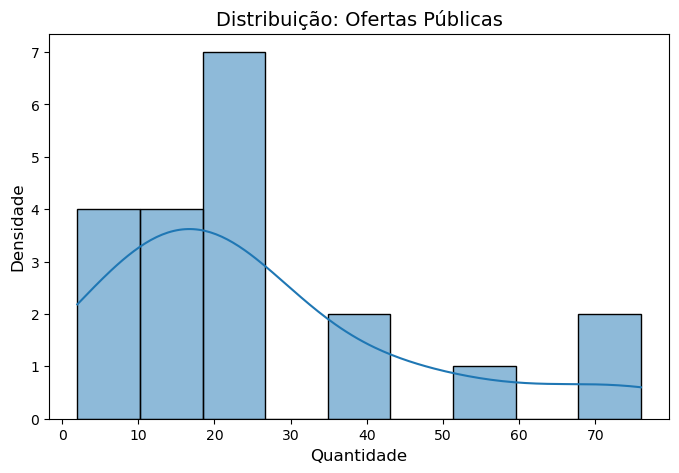

In [6]:
plt.figure(figsize=(8, 5))

sns.histplot(df['OFERTAS'], bins = 9, kde=True)

plt.title('Distribuição: Ofertas Públicas', fontsize=14)

plt.xlabel('Quantidade', fontsize=12)
plt.ylabel('Densidade', fontsize=12)

plt.show()

### Variável Dependentes: SELIC, PIB e EMBI

Abaixo podemos visualizar a relação entre algumas variáveis dependentes e ter uma certa intuição da relação entre elas o número de ofertas públicas, por exemplo, em 2014-2016 tivemos um PIB em queda, um juros crescente assim como o risco pais. 

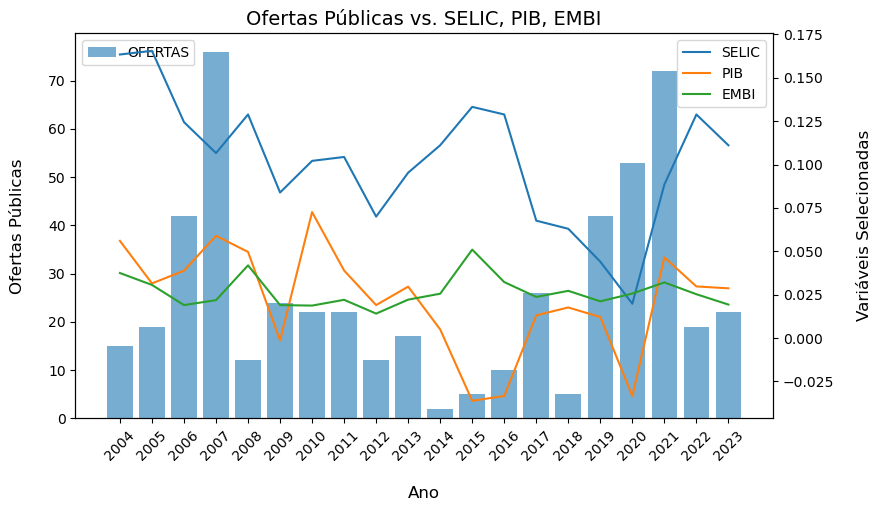

In [7]:
fig, ax1 = plt.subplots(figsize=(9,5))

plt.title('Ofertas Públicas vs. SELIC, PIB, EMBI', fontsize = 14)

ax1.bar(df.index, df['OFERTAS'], alpha=0.6, label = 'OFERTAS')

ax2 = ax1.twinx()  

ax2.plot(df.index, (df[['SELIC', 'PIB', 'EMBI']]), 
         label=df[['SELIC', 'PIB', 'EMBI']].columns)

ax1.set_ylabel('Ofertas Públicas\n', fontsize = 12)
ax2.set_ylabel('\nVariáveis Selecionadas', fontsize = 12)

ax1.set_xlabel('\nAno', fontsize = 12)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_xticks(np.arange(df.index[0], df.index[-1] + 1, 1))
ax1.set_xticklabels(np.arange(df.index[0], df.index[-1] + 1, 1), rotation=45)

plt.show()

Abaixo podemos visualizar uma relação negativa com a taxa de câmbio, como em 2008 e 2014-2016 e uma relação não tão evidente com o Ibovespa, por exemplo, em 2008 teve uma forte alta do Ibovespa porém um baixo número de ofertas públicas.

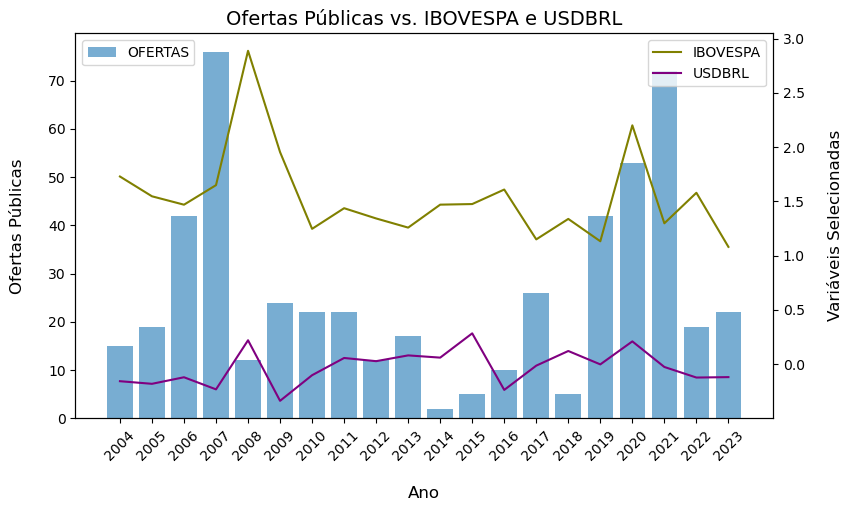

In [8]:
fig, ax1 = plt.subplots(figsize=(9, 5))

plt.title('Ofertas Públicas vs. IBOVESPA e USDBRL', fontsize=14)

ax1.bar(df.index, df['OFERTAS'], alpha=0.6, label='OFERTAS')

ax2 = ax1.twinx()

ax2.plot(df.index, df['IBOVESPA'], label='IBOVESPA', color='olive')
ax2.plot(df.index, df['USDBRL'], label='USDBRL', color='purple')

ax1.set_ylabel('Ofertas Públicas\n', fontsize=12)
ax2.set_ylabel('\nVariáveis Selecionadas', fontsize=12)
ax1.set_xlabel('\nAno', fontsize=12)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_xticks(np.arange(df.index[0], df.index[-1] + 1, 1))
ax1.set_xticklabels(np.arange(df.index[0], df.index[-1] + 1, 1), rotation=45)

plt.show()

### Box Plot

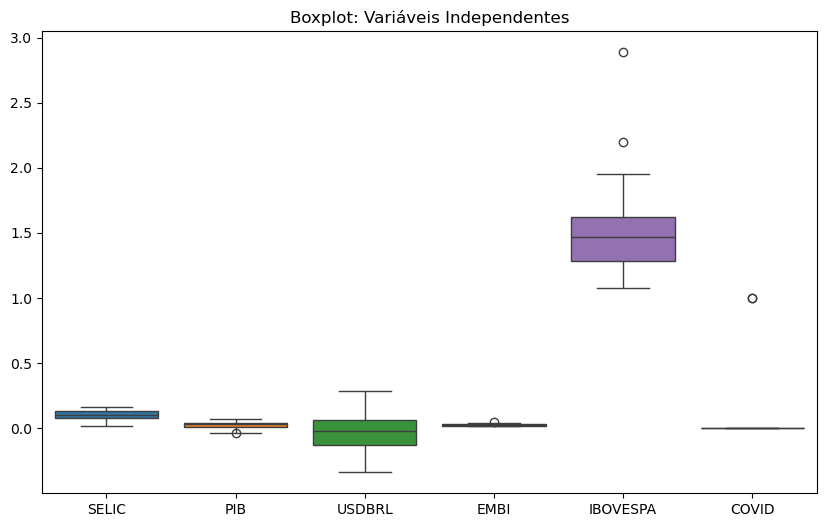

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(df.iloc[:,1:])
plt.title('Boxplot: Variáveis Independentes')
plt.show()

### Heatmap

Abaixo podemos visualizar a correlação das nossas variáveis, a correlação com ofertas públicas seguiu o que seria previsto: há uma correlação positiva (+) com PIB e negativa (-) com SELIC, USDBRL, EMBI e pouco expressiva com IBOVESPA que pode indicar a inexistência de relação entre as variáveis. 

<Axes: >

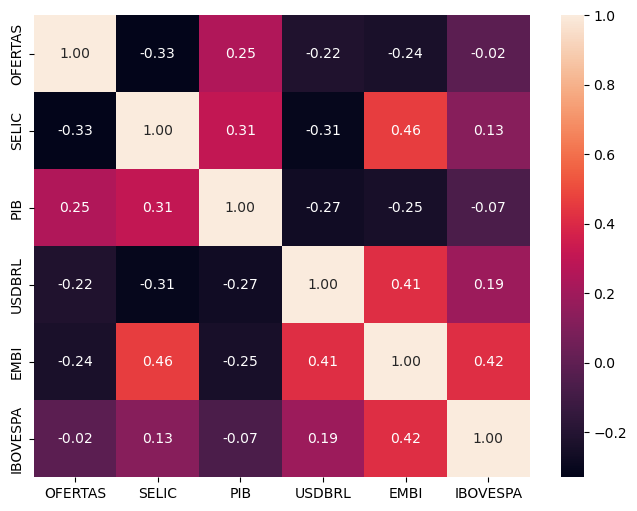

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df.iloc[:,:6].corr(), annot=True, fmt=".2f", annot_kws={'size': 10})

## Modelo de Regressão Poisson

Os modelos de regressão poisson são utilizados quando a variável dependente é discreta assumindo valores naturais e positivos, por exemplo, o número de camisetas no inventário de uma loja. Como o próprio nome sugere, esta variável segue uma distribuição poisson no seguinte formato: 

$$ P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!} $$

onde:

- $ \lambda $ é o parâmetro de taxa (média de ocorrências),
- $ k $ é o número de ocorrências,
- $ e $ é o número de Euler,
- $ k! $ é o fatorial de $ k $.

Podemos modelar a função do nosso parâmetro de interesse $ \lambda $ como sendo igual a:

$$
\ln(\lambda) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n
$$

ou

$$
\lambda = e^{(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n)}
$$

A estimação do modelo é feito por máxima verossimilhança (*maximum likelihood*), como o próprio nome sugere este método busca encontrar os parâmetros ($\beta$) que maximizem a probabilidade (*likelihood*) de obter a amostra observada. No caso, como trata-se de dados que seguem uma distribuição poisson podemos representar uma função de verossimilhança como:
 
$$
L = \prod_{i=1}^{n} \frac{\lambda^k e^{-\lambda}}{k!}
$$

O problema de optimização é maximizar a função *log-likelihood* que é o logarítmo natural da função de verossimilhança. 

$$
LL = \sum_{i=1}^{n} \left( - \lambda_i + Y_i \ln(\lambda_i)  - \ln(Y_i!) \right)
$$

A derivação detalhada pode ser encontrada no livro Manual de Análise de Dados do Favero. 

In [11]:
# Variáveis independentes
df.columns[1:]

Index(['SELIC', 'PIB', 'USDBRL', 'EMBI', 'IBOVESPA', 'COVID'], dtype='object')

In [12]:
# Modelo com todas as variáveis 
modelo = smf.glm(formula='OFERTAS ~ SELIC + PIB + USDBRL + EMBI + IBOVESPA + COVID',
                 data=df,
                 family=sm.families.Poisson()).fit()

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                OFERTAS   No. Observations:                   20
Model:                            GLM   Df Residuals:                       13
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -92.462
Date:                Sun, 27 Oct 2024   Deviance:                       89.505
Time:                        11:54:11   Pearson chi2:                     85.0
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4735      0.247     14.070      0.000       2.990       3.957
SELIC        -10.3736      2.593     -4.001      0.000     -15.455      -5.292
PIB           12.5334      2.027      6.184      0.000       8.561      16.506
USDBRL        -2.4176      0.397     -6.092      0.000      -3.195      -1.640
EMBI          -9.4065     11.362     -0.828      0.408     -31.675      12.862
IBOVESPA       0.2627      0.132      1.988      0.047       0.004       0.522
COVID          1.1361      0.160      7.082      0.000       0.822       1.450
==============================================================================
"""

In [13]:
# Modelo com variáveis estatisticamente significativas
modelo = smf.glm(formula='OFERTAS ~ SELIC + PIB + USDBRL + COVID',
                 data=df,
                 family=sm.families.Poisson()).fit()

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                OFERTAS   No. Observations:                   20
Model:                            GLM   Df Residuals:                       15
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94.473
Date:                Sun, 27 Oct 2024   Deviance:                       93.528
Time:                        11:54:11   Pearson chi2:                     89.5
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7501      0.157     23.821      0.000       3.442       4.059
SELIC        -11.1502      1.760     -6.335      0.000     -14.600      -7.700
PIB           11.3636      1.793      6.336      0.000       7.849      14.879
USDBRL        -2.5519      0.357     -7.157      0.000      -3.251      -1.853
COVID          1.0808      0.118      9.138      0.000       0.849       1.313
==============================================================================
"""

In [14]:
modelo.params

Intercept     3.750087
SELIC       -11.150240
PIB          11.363643
USDBRL       -2.551941
COVID         1.080759
dtype: float64

In [16]:
var_dependentes = df[['SELIC', 'PIB', 'USDBRL', 'COVID']]

oferta_previsto = np.exp(
    modelo.params[0] + 
    modelo.params[1] * var_dependentes['SELIC'] +
    modelo.params[2] * var_dependentes['PIB'] +
    modelo.params[3] * var_dependentes['USDBRL'] +
    modelo.params[4] * var_dependentes['COVID']
)

oferta_previsto

Ano
2004    19.405179
2005    15.253234
2006    22.470287
2007    45.775002
2008    10.135559
2009    38.946010
2010    40.304329
2011    17.882931
2012    22.552823
2013    16.749755
2014    11.185764
2015     3.095043
2016    12.682602
2017    24.038905
2018    18.897428
2019    30.042451
2020    40.282739
2021    84.717261
2022    19.425950
2023    23.156747
dtype: float64

In [17]:
# Prova real
modelo.fittedvalues

Ano
2004    19.405179
2005    15.253234
2006    22.470287
2007    45.775002
2008    10.135559
2009    38.946010
2010    40.304329
2011    17.882931
2012    22.552823
2013    16.749755
2014    11.185764
2015     3.095043
2016    12.682602
2017    24.038905
2018    18.897428
2019    30.042451
2020    40.282739
2021    84.717261
2022    19.425950
2023    23.156747
dtype: float64

## Superdispersão

Uma das hipóteses da distribuição Poisson é que a variância e a média são iguais, isso é uma hipótese importante a ser testada pois caso violado o nosso modelo pode acabar gerando parâmetros viesados (mesmo que sejam estatisticamente significativos), esse problema é chamado de superdispersão. Como vemos abaixo, a nossa amostra de dados indica a existência de superdispersão. Segundo Favero, um método desenvolvido por Cameron e Trivedi é rodar uma regressão entre os valores previstos (fitted values) pelo modelo poisson estimado e pelo Y* que é calculado segundo a fórmula abaixo: 

$${Y_i}^* = \frac{[(Y_i - \lambda_i)^2 - Y_i]}{\lambda_i}$$ 

Rodar a regressão e verificar se o $\beta$ é superior a 5%, caso seja há equidispersão, caso contrário há superdispersão. 

$$\hat{Y_i}^* = \beta . \lambda_i$$

In [18]:
df['lambda_poisson'] = modelo.fittedvalues

df['ystar'] = (((df['OFERTAS'] - df['lambda_poisson'])**2) - df['OFERTAS']) / df['lambda_poisson']

modelo_auxiliar = sm.OLS.from_formula('ystar ~ 0 + lambda_poisson', df).fit()

modelo_auxiliar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ystar   R-squared (uncentered):                   0.311
Model:                            OLS   Adj. R-squared (uncentered):              0.275
Method:                 Least Squares   F-statistic:                              8.588
Date:                Sun, 27 Oct 2024   Prob (F-statistic):                     0.00858
Time:                        11:55:12   Log-Likelihood:                         -62.106
No. Observations:                  20   AIC:                                      126.2
Df Residuals:                      19   BIC:                                      127.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
lambda_poisson     0.1165      0.040      2.931      0.009       0.033       0.200
==============================================================================
Omnibus:                        5.534   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                3.580
Skew:                           1.012   Prob(JB):                        0.167
Kurtosis:                       3.446   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Validando com a função overdisp
from statstests.tests import overdisp

overdisp(modelo, df)

Estimating model...: 
 GLM
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.275   
Dependent Variable:     ystar            AIC:                         126.2120
Date:                   2024-10-27 11:55 BIC:                         127.2078
No. Observations:       20               Log-Likelihood:              -62.106 
Df Model:               1                F-statistic:                 8.588   
Df Residuals:           19               Prob (F-statistic):          0.00858 
R-squared (uncentered): 0.311            Scale:                       30.693  
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
lmbda          0.1165        0.0398      2.9305      0.0086      0.0333      0.1998
-----------------------------

## Modelo Binomial Negativo (Poisson Gama)

Indicado quando há indício de superdispersão, segue uma distribuição Poisson-Gama que apresenta uma dispersão maior do que a binomial. 

$$ P(X = k) = \frac{\delta^\psi . v_i^{\psi-1} e^{-v_i . \delta}}{\Gamma (\psi)} $$

Onde: 

- $\delta$ = Parâmetro de forma
- $\psi$ = Parâmetro de decaimento (taxa)

Um parâmetro importante é o $\phi$ que é igual a $\frac{1}{\delta}$, este $\phi$ será utilizado no modelo do statamodels como o parâmetro (alpha = i). O objetivo é encontrar o $\phi$ que maximize o log-likelihood do modelo, ou seja, estamos diante de um problema de optimização e uma solução é rodar várias modelos com diferentes $\phi$. 

In [20]:
alphas = np.linspace(0.01, 10, 100)

# log-likelihood
llf = []

# Loop que calcula o llf para cada valor de alpha no modelo
for i in alphas: 
    model = smf.glm(formula='OFERTAS ~ SELIC + PIB + USDBRL + COVID',
                    data=df,
                    family=sm.families.NegativeBinomial(alpha=i)).fit()
    llf.append(model.llf)

In [21]:
phi = pd.DataFrame()

phi['llf'] = llf
phi['alphas'] = alphas

phi

,llf,alphas
0,-86.530228,0.010000
1,-73.403922,0.110909
2,-73.295834,0.211818
3,-74.303695,0.312727
4,-75.497387,0.413636
...,...,...
95,-109.729300,9.596364
96,-109.894719,9.697273
97,-110.058685,9.798182
98,-110.221224,9.899091


In [22]:
# phi associado
phi_otimo = phi['alphas'].iloc[np.nanargmax(phi['llf'])]
phi_otimo

0.21181818181818182

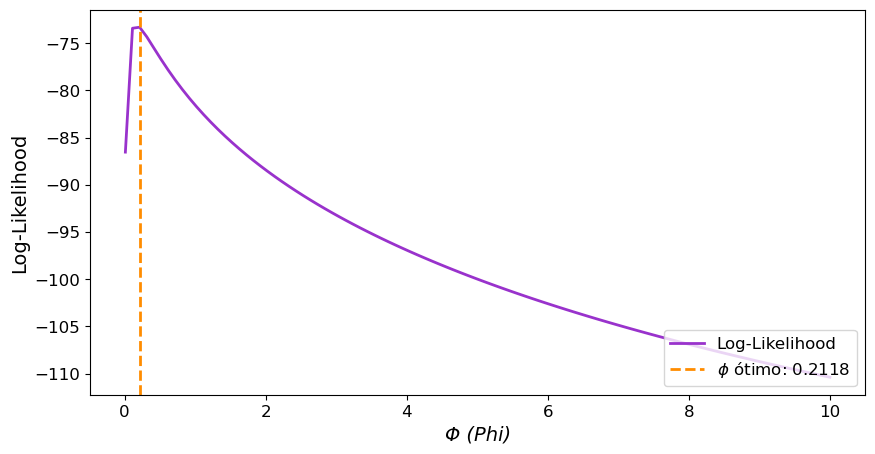

In [23]:
plt.figure(figsize=(10, 5))

plt.plot(phi['alphas'], phi['llf'], label='Log-Likelihood', color='darkorchid', linewidth = 2)

plt.axvline(x=phi_otimo, color='darkorange', linewidth = 2, linestyle='dashed',
            label=f'$\phi$ ótimo: {round(phi_otimo, 4)}')

plt.xlabel('Φ (Phi)', fontsize=14, style='italic')
plt.ylabel('Log-Likelihood', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='lower right', fontsize=12)

plt.show()

### Modelo Binomial Negativo - Final

Rodamos o modelo com o "phi" ótimo e todas as variáveis continuaram sendo estatisticamente significativas, como pode-se ver ele também teve um log-likelihood menor do que o modelo Poisson feito anteriormente. 

In [24]:
modelo_bneg = smf.glm(formula='OFERTAS ~ SELIC + PIB + USDBRL + COVID',
                      data=df,
                      family=sm.families.NegativeBinomial(alpha=phi_otimo)).fit()

modelo_bneg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                OFERTAS   No. Observations:                   20
Model:                            GLM   Df Residuals:                       15
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -73.296
Date:                Sun, 27 Oct 2024   Deviance:                       17.390
Time:                        11:55:14   Pearson chi2:                     14.5
No. Iterations:                     7   Pseudo R-squ. (CS):             0.7932
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5576      0.401      8.872      0.000       2.772       4.344
SELIC         -9.5834      3.905     -2.454      0.014     -17.237      -1.929
PIB           11.9203      4.356      2.737      0.006       3.383      20.458
USDBRL        -2.4483      0.822     -2.980      0.003      -4.059      -0.838
COVID          1.2619      0.407      3.102      0.002       0.464       2.059
==============================================================================
"""

## Comparação Poisson e Binomial Negativo

Abaixo temos um comparativo de ambos os modelos, podemos ver que os parâmetros (𝛽) das funções de regressão mudaram e no modelo Poisson-Gama tivemos um log-likelihood (LL) menor.

In [25]:
summary_col([modelo, modelo_bneg], 
            model_names=["Poisson","BNeg"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
            })

,Poisson,BNeg
Intercept,3.7501***,3.5576***
,(0.1574),(0.4010)
SELIC,-11.1502***,-9.5834**
,(1.7602),(3.9052)
PIB,11.3636***,11.9203***
,(1.7935),(4.3560)
USDBRL,-2.5519***,-2.4483***
,(0.3566),(0.8217)
COVID,1.0808***,1.2619***
,(0.1183),(0.4068)


### Teste $\chi^2$

Para verificar se a diferença dos LL dos modelos são estatisticamente diferentes, fazemos o teste de 𝜒2 calculando o Likelihood Ratio (LR) e rodando no teste "chi" disponível na biblioteca statsmodels. Obtemos um p-valor baixíssimo e rejeitamos a hipótese nula que os modelos produzem LL estatisticamente iguais. 

In [26]:
llk_p = modelo.llf
llk_bneg = modelo_bneg.llf

LR_statistic = -2*(llk_p-llk_bneg)
p_val = stats.chi2.sf(LR_statistic, 1)

print('Likelihood Ratio (LR):', LR_statistic)
print('p-valor:', p_val)

Likelihood Ratio (LR): 42.35428099547008
p-valor: 7.614946900215659e-11


## Valores Estimados e Observados

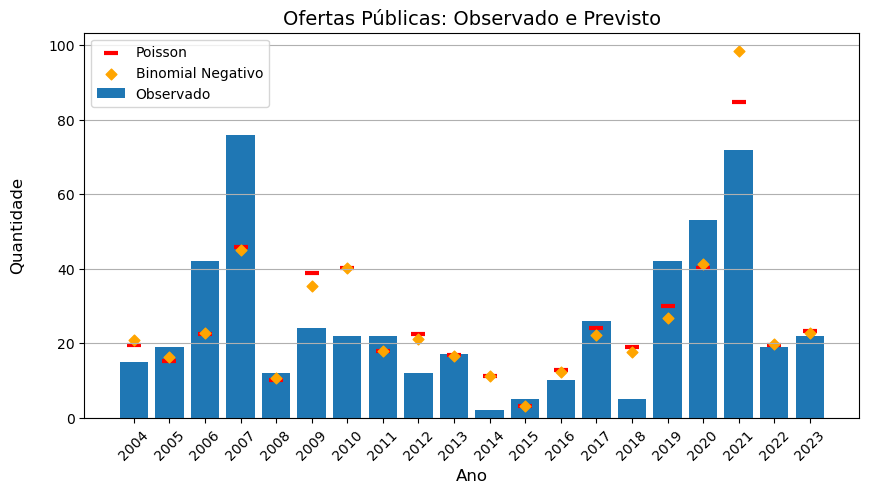

In [27]:
y = df['OFERTAS']
y_poisson = modelo.fittedvalues
y_bneg = modelo_bneg.fittedvalues

plt.figure(figsize=(10,5))

plt.title('Ofertas Públicas: Observado e Previsto', fontsize=14)

plt.bar(df.index, y, label = 'Observado')
plt.scatter(df.index, y_poisson, label = 'Poisson', color = 'red', marker='_', s= 100, linewidths=3)
plt.scatter(df.index, y_bneg, label = 'Binomial Negativo', color = 'orange', marker='D', s= 30, linewidths=1)

plt.xticks(np.arange(df.index[0], df.index[-1] + 1, 1), rotation=45)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Quantidade\n', fontsize=12)

plt.legend()

plt.grid(axis='y')
plt.show()

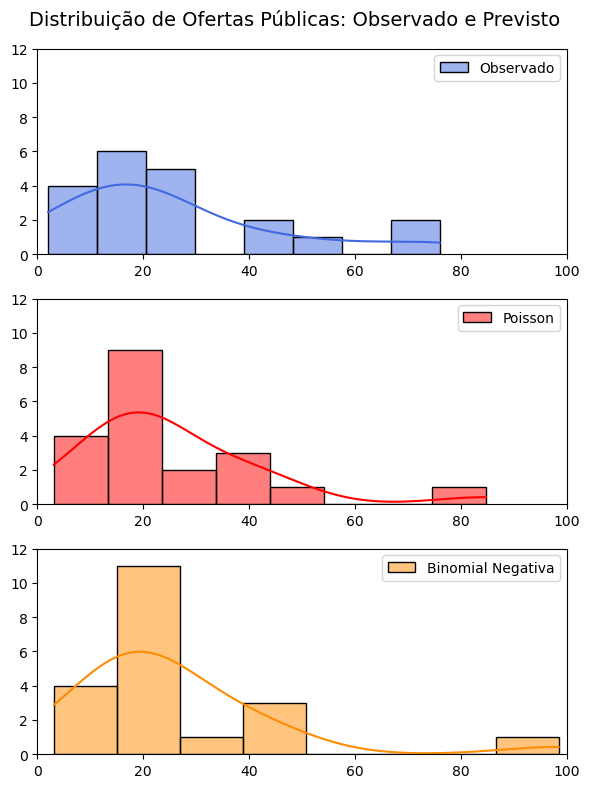

In [28]:
dic = {'Observado': df['OFERTAS'],
         'Poisson': y_poisson,
         'Binomial Negativa': y_bneg}

cores = ['royalblue', 'red', 'darkorange']

plt.figure(figsize=(6,8))
    
plt.suptitle('Distribuição de Ofertas Públicas: Observado e Previsto', fontsize=14)

Abaixo podemos visualizar e comparação os resultados finais e verificar que os valores previstos conseguiram capturar movimentos de ofertas públicas realizadas durante o período de 2004 e 2023 com base nas variáveis macroeconômicas PIB, SELIC e USDBRL. Em ambos os modelos, obtemos uma relação positiva com PIB e negativa com SELIC e USDBRL o que nos leva a concluir que um ambiente macroeconômico estável sem variações abruptas da taxa de câmbio, uma taxa de juros mais baixa e uma economia pujante leva as empresas a realizarem mais ofertas públicas.

for i, (nome, dados) in enumerate(dic.items(), start=1):
    
    plt.subplot(3, 1, i)
    
    sns.histplot(dados, bins=8, kde=True, label=nome, color=cores[i-1])
    
    plt.ylabel('', fontsize=12)
    plt.xlabel('', fontsize=12)
    
    plt.xlim(0, 100)
    plt.ylim(0, 12)
    
    plt.legend()
    
plt.tight_layout(rect=[0, 0, 1, 1])